### 주제 선정 : ?

### 분석 배경 : 
최근 들어 'Scale 불량 발생 증가'라는 이슈가 발생했다. 그 원인을 분석해 본 결과 압연공정에서 Scale 불량이 급증한 것을 확인할 수 있었다. 불량 발생의 근본 원인을 찾고 결과를 해석하여 개선 기회를 도출한다.

### 분석 목적 :

### 예상 목표 :

### 분석 계획

탐색적 분석/전처리 - 모델링/요약 - 결론/개선방향 - 배운점


In [1]:
##패키지 불러오기

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib
import matplotlib as mpl

import seaborn as sns

from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

from sklearn.model_selection import train_test_split

from sklearn.tree import export_graphviz
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import f1_score, roc_curve, auc

from sklearn.metrics import confusion_matrix

#경고창 제거
import warnings
warnings.filterwarnings('ignore')

In [2]:
#한글 적용
from matplotlib import font_manager, rc
import matplotlib.font_manager as fm
mpl.rc('font',family= 'Malgun Gothic')
font_manager.get_fontconfig_fonts()
fontname = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
fontname = font_manager.FontProperties(fname=fontname).get_name()
plt.style.use('seaborn-white')
rc('font', family=fontname)

## 1. 데이터 구성하기

In [3]:
df_raw = pd.read_csv("/home/pirl/Downloads/data2/SCALE불량.csv", encoding='CP949')
#df_raw = pd.read_csv("C:/Users/admin/Desktop/AI BigData/Python/3. Big Data 분석/SCALE불량.csv", encoding='CP949')
df_raw.head()

,PLATE_NO,ROLLING_DATE,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,...,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,PB562774,2008-08-01:00:00:15,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,116,1133,59,282,1133,934,적용,8,2조
1,PB562775,2008-08-01:00:00:16,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,...,1144,122,1135,53,283,1135,937,적용,8,2조
2,PB562776,2008-08-01:00:00:59,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1129,116,1121,55,282,1121,889,적용,8,3조
3,PB562777,2008-08-01:00:01:24,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,...,1152,125,1127,68,316,1127,885,적용,8,3조
4,PB562778,2008-08-01:00:01:44,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,...,1140,134,1128,48,314,1128,873,적용,8,1조


In [4]:
from IPython.display import Image

*데이터 설명*

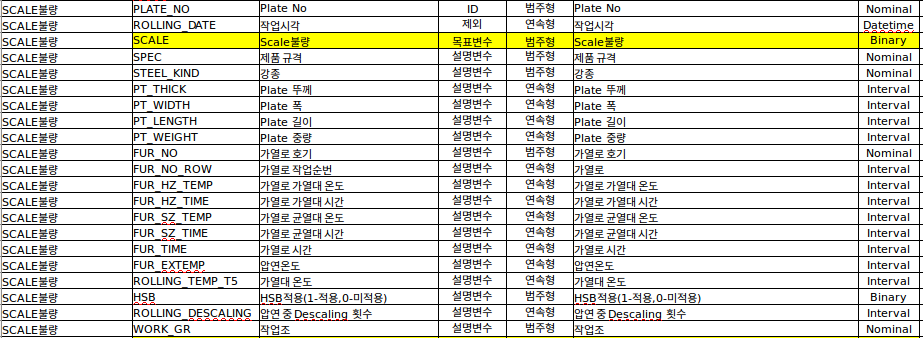

## 2. 탐색적 자료 분석 및 데이터 정제

In [5]:
#결측치 확인
df_raw.isnull().sum()

PLATE_NO             0
ROLLING_DATE         0
SCALE                0
SPEC                 0
STEEL_KIND           0
PT_THK               0
PT_WDTH              0
PT_LTH               0
PT_WGT               0
FUR_NO               0
FUR_NO_ROW           0
FUR_HZ_TEMP          0
FUR_HZ_TIME          0
FUR_SZ_TEMP          0
FUR_SZ_TIME          0
FUR_TIME             0
FUR_EXTEMP           0
ROLLING_TEMP_T5      0
HSB                  0
ROLLING_DESCALING    0
WORK_GR              0
dtype: int64

결측치는 없음을 알 수 있다.

In [6]:
df_raw.shape

(720, 21)

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 21 columns):
PLATE_NO             720 non-null object
ROLLING_DATE         720 non-null object
SCALE                720 non-null object
SPEC                 720 non-null object
STEEL_KIND           720 non-null object
PT_THK               720 non-null float64
PT_WDTH              720 non-null int64
PT_LTH               720 non-null int64
PT_WGT               720 non-null int64
FUR_NO               720 non-null object
FUR_NO_ROW           720 non-null int64
FUR_HZ_TEMP          720 non-null int64
FUR_HZ_TIME          720 non-null int64
FUR_SZ_TEMP          720 non-null int64
FUR_SZ_TIME          720 non-null int64
FUR_TIME             720 non-null int64
FUR_EXTEMP           720 non-null int64
ROLLING_TEMP_T5      720 non-null int64
HSB                  720 non-null object
ROLLING_DESCALING    720 non-null int64
WORK_GR              720 non-null object
dtypes: float64(1), int64(12), object(8)
memo

In [8]:
df_raw.select_dtypes('object').apply(pd.Series.nunique, axis=0)

PLATE_NO        720
ROLLING_DATE    704
SCALE             2
SPEC             66
STEEL_KIND        9
FUR_NO            3
HSB               2
WORK_GR           4
dtype: int64

PLATE_NO, ROLLING_DATE 을 제거한다. (SCALE은 목표변수)

In [9]:
df_raw = df_raw.drop(['PLATE_NO', 'ROLLING_DATE'],axis=1)
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,1133,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,1135,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,1121,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,1127,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,1128,873,적용,8,1조


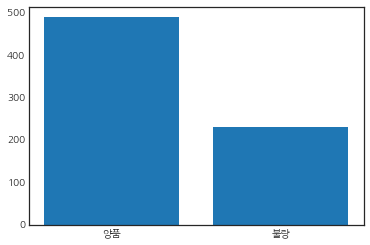

In [10]:
#목표변수에 대한 막대차트
scale = df_raw['SCALE'].value_counts()
plt.bar(scale.index, scale)
plt.show()

### 범주형 자료에 대한 막대차트

* SPEC : 제품 규격
* STEEL_KIND : 강종
* FUR_NO : 가열로 호기
* HSB : HSB 적용 유무
* WORK_GR : 작업조

In [11]:
#범주형 자료에 대한 막대차트
def bar_chart(feature) :
    good = df_raw[df_raw['SCALE']=='양품'][feature].value_counts()
    bad = df_raw[df_raw['SCALE']=='불량'][feature].value_counts()
    df = pd.DataFrame([good, bad])
    df.index =['양품', '불량']
    df.plot(kind='bar',stacked=True, figsize=(10,5))

*SPEC 은 자료의 수가 많기 때문에 비교하기 어려우므로 생략*

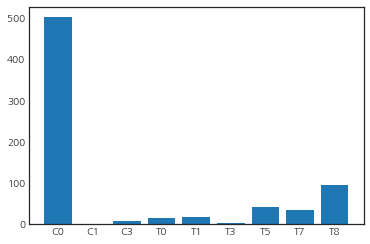

In [12]:
#STEEL_KIND : 강종
SK = df_raw['STEEL_KIND'].value_counts().sort_index()
plt.bar(SK.index,SK)
plt.show()

강종은 C0, T8, T5 순으로 많음을 볼 수 있다.

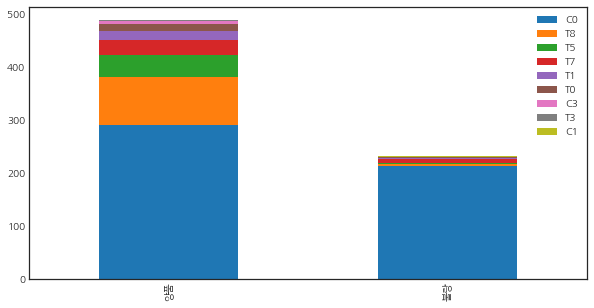

In [13]:
bar_chart('STEEL_KIND')

C0은 양품이 많지만 불량도 많음을 알 수 있고, T8의 경우 양품대비 불량의 수가 비교적 적음을 알 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

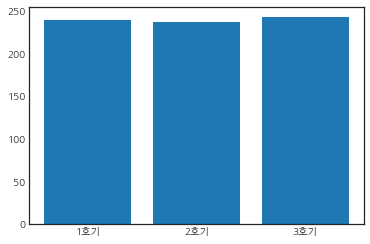

In [14]:
#FUR_NO : 가열로 호기
FN = df_raw['FUR_NO'].value_counts().sort_index()
plt.bar(FN.index, FN)
plt.show

가열로의 호기에서 생상되는 양에는 큰 차이가 없다.

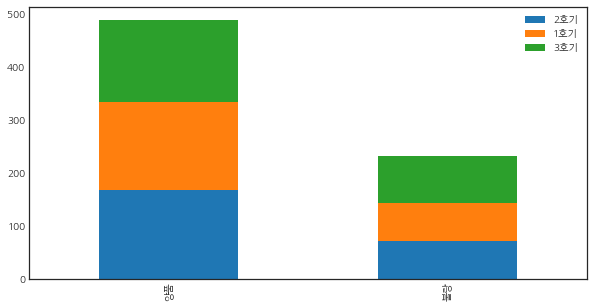

In [15]:
bar_chart('FUR_NO')

각각 양품과 불량을 생산하는 것에 큰 차이는 없다.

<function matplotlib.pyplot.show(*args, **kw)>

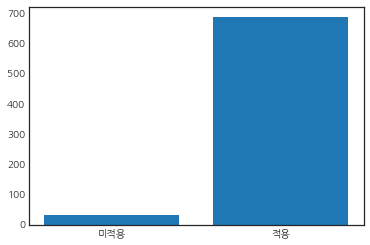

In [16]:
#HSB : HSB 적용 유무 (1-적용, 0-미적용)
HSB = df_raw['HSB'].value_counts().sort_index()
plt.bar(HSB.index, HSB)
plt.show

In [17]:
#적용과 미적용의 차이가 나므로 수치로 확인해본다.
print(HSB)

미적용     33
적용     687
Name: HSB, dtype: int64


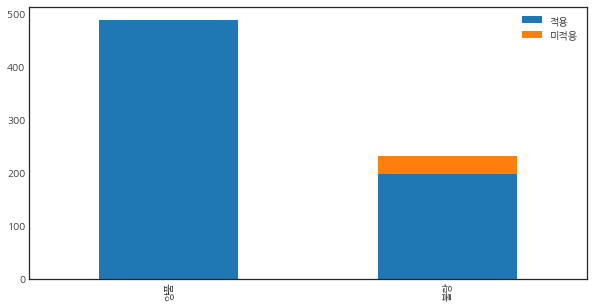

In [18]:
bar_chart('HSB')

HSB를 미적용한 경우는 100% 불량이 나왔음을 알 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

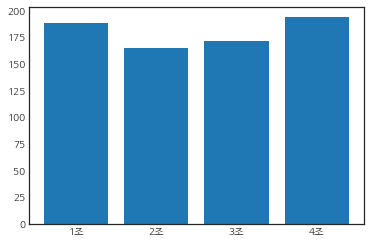

In [19]:
#WORK_GR : 작업조
WG = df_raw['WORK_GR'].value_counts().sort_index()
plt.bar(WG.index, WG)
plt.show

In [20]:
print(WG)

1조    189
2조    165
3조    172
4조    194
Name: WORK_GR, dtype: int64


생산량은 4조, 1조, 3조, 2조 순으로 많음을 알 수 있다.

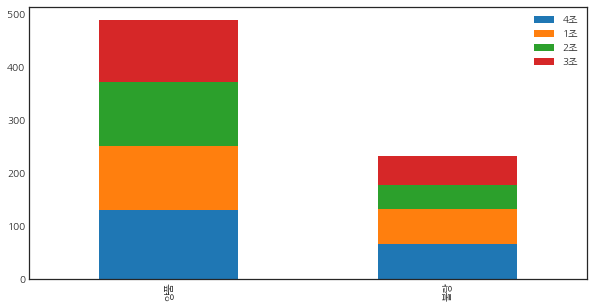

In [21]:
bar_chart('WORK_GR')

생산조에 따른 양품과 불량에 대한 차이는 거의 없어 보인다.

### 연속형 자료
* PT_THK : Plate 두께
* PT_WDTH : Plate 폭
* PT_LTH : Plate 길이
* PT_WGT : Plate 중량
* FUR_NO_ROW :가열로 작업순번
* FUR_HZ_TEMP : 가열로 가열대 온도
* FUR_HZ_TIME : 가열로 가열대 시간
* FUR_SZ_TEMP : 가열로 균열대 온도
* FUR_SZ_TIME : 가열로 균일대 시간
* FUR_TIME : 가열로 시간
* FUR_EXTEMP : 압연 온도
* ROLLING_TEMP_T5 : 가열대 온도
* ROLLING_DESCALING : 압연 중 Descaling 횟수

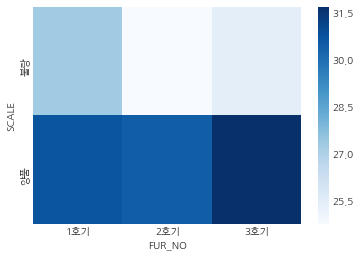

In [22]:
#scale 불량여부,가열로 호기별 plate 두께 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','PT_THK')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 두께가 두꺼움을 알 수 있다.

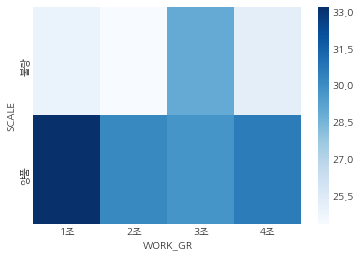

In [23]:
#scale 불량여부, 작업조별 plate 두께 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_THK')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 두께가 두거움을 알 수 있다. 3조에서 생산하는 철판의 두께는 양품과 불량사이에 큰 차이가 없다.

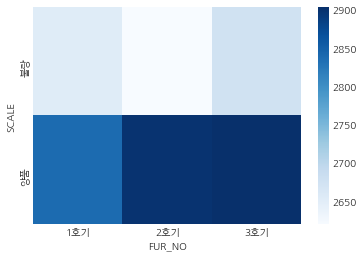

In [24]:
#scale 불량여부,가열로 호기별 plate 폭 평균 계산 : 히트맵

df_plate_wdth = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_wdth.pivot('SCALE','FUR_NO','PT_WDTH')
sns.heatmap(df_pivot, cmap="Blues")

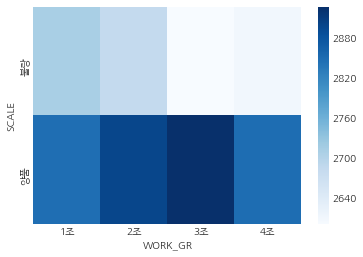

In [25]:
#scale 불량여부, 작업조별 plate 폭 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_WDTH')
sns.heatmap(df_pivot, cmap="Blues")

양품일수록 철판의 폭이 큼을 알 수 있다.

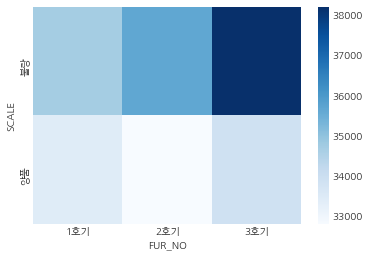

In [26]:
#scale 불량여부, 가열로 호기별 plate 길이 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','PT_LTH')
sns.heatmap(df_pivot, cmap="Blues")

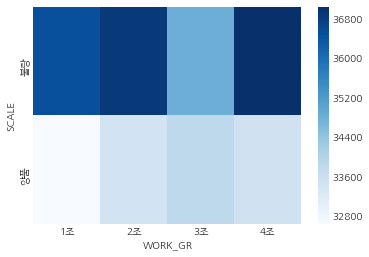

In [27]:
#scale 불량여부, 작업조별 plate 길이 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_LTH')
sns.heatmap(df_pivot, cmap="Blues")

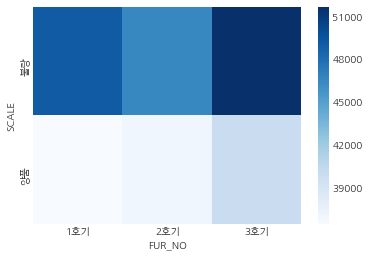

In [28]:
#scale 불량여부, 가열로 호기별 plate 중량 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','PT_WGT')
sns.heatmap(df_pivot, cmap="Blues")

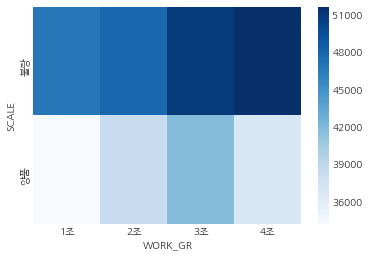

In [29]:
#scale 불량여부, 작업조별 plate 중량 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','PT_WGT')
sns.heatmap(df_pivot, cmap="Blues")

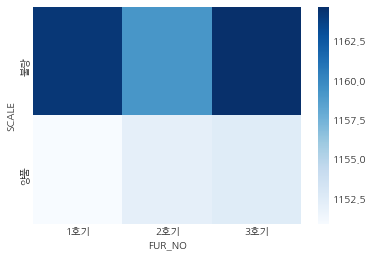

In [30]:
#scale 불량여부, 가열로 호기별 가열로 가열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_HZ_TEMP')
sns.heatmap(df_pivot, cmap="Blues")

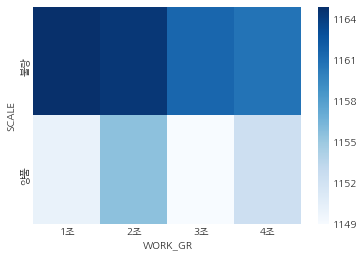

In [31]:
#scale 불량여부, 작업조별 가열로 가열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_HZ_TEMP')
sns.heatmap(df_pivot, cmap="Blues")

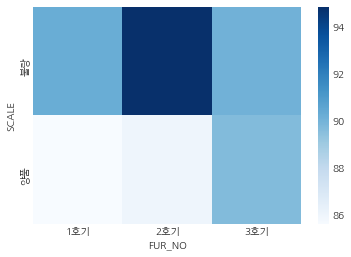

In [32]:
#scale 불량여부, 가열로 호기별 가열로 가열대 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_HZ_TIME')
sns.heatmap(df_pivot, cmap="Blues")

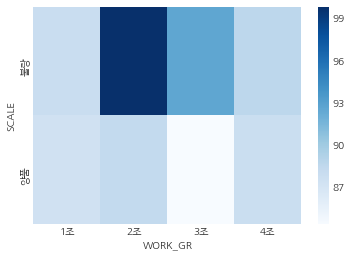

In [33]:
#scale 불량여부, 작업조별 가열로 가열대 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_HZ_TIME')
sns.heatmap(df_pivot, cmap="Blues")

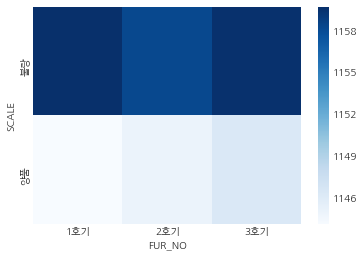

In [34]:
#scale 불량여부, 가열로 호기별 가열로 균열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_SZ_TEMP')
sns.heatmap(df_pivot, cmap="Blues")

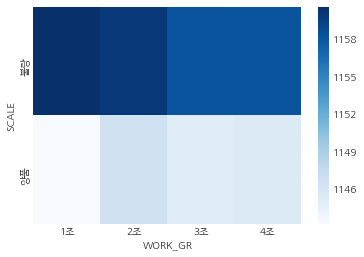

In [35]:
#scale 불량여부, 작업조별 가열로 균열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_SZ_TEMP')
sns.heatmap(df_pivot, cmap="Blues")

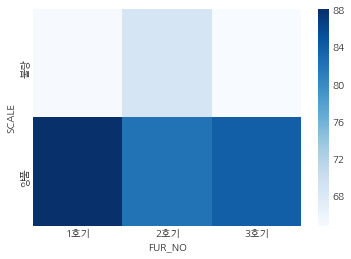

In [36]:
#scale 불량여부, 가열로 호기별 가열로 균열대 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_SZ_TIME')
sns.heatmap(df_pivot, cmap="Blues")

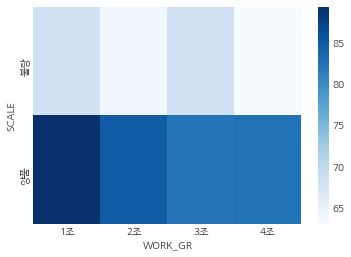

In [37]:
#scale 불량여부, 작업조별 가열로 균열대 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_SZ_TIME')
sns.heatmap(df_pivot, cmap="Blues")

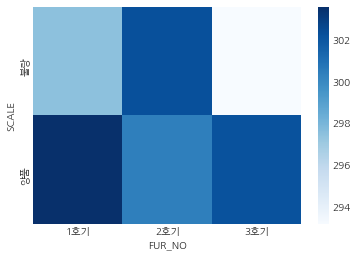

In [38]:
#scale 불량여부, 가열로 호기별 가열로 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_TIME')
sns.heatmap(df_pivot, cmap="Blues")

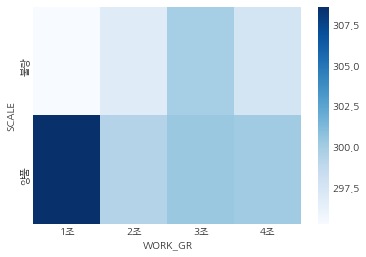

In [39]:
#scale 불량여부, 작업조별 가열로 시간 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_TIME')
sns.heatmap(df_pivot, cmap="Blues")

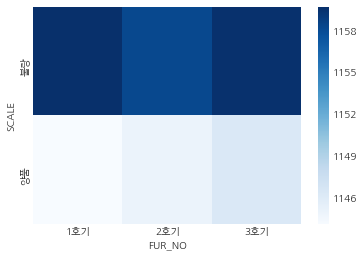

In [40]:
#scale 불량여부, 가열로 호기별 압연온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','FUR_EXTEMP')
sns.heatmap(df_pivot, cmap="Blues")

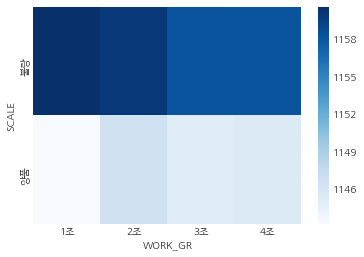

In [41]:
#scale 불량여부, 작업조별 압연온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','FUR_EXTEMP')
sns.heatmap(df_pivot, cmap="Blues")

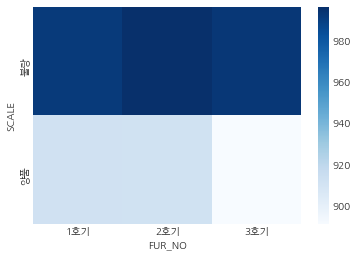

In [42]:
#scale 불량여부, 가열로 호기별 가열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','ROLLING_TEMP_T5')
sns.heatmap(df_pivot, cmap="Blues")

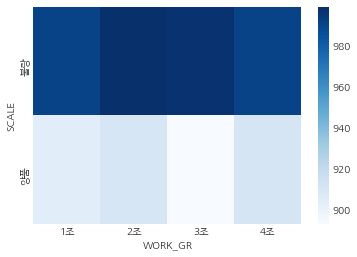

In [43]:
#scale 불량여부, 작업조별 가열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','ROLLING_TEMP_T5')
sns.heatmap(df_pivot, cmap="Blues")

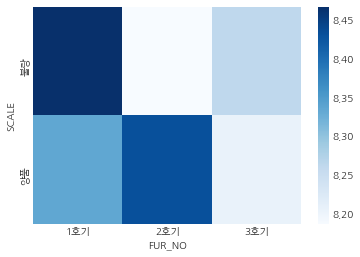

In [44]:
#scale 불량여부, 가열로 호기별 압연 중 descaling 횟수 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','FUR_NO'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','FUR_NO','ROLLING_DESCALING')
sns.heatmap(df_pivot, cmap="Blues")

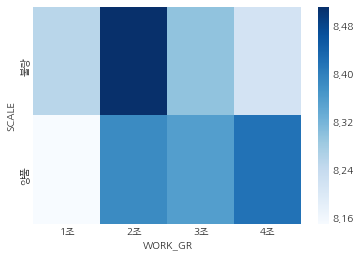

In [45]:
#scale 불량여부, 작업조별 가열대 온도 평균 계산 : 히트맵

df_plate_thk = df_raw.groupby(['SCALE','WORK_GR'], as_index=False).agg('mean')
df_pivot = df_plate_thk.pivot('SCALE','WORK_GR','ROLLING_DESCALING')
sns.heatmap(df_pivot, cmap="Blues")

### 상자그림

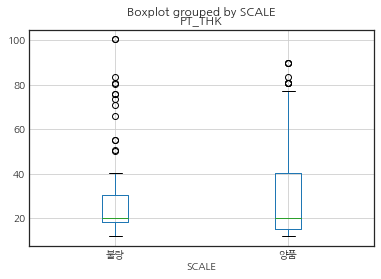

In [46]:
#1. PT_THK
df_raw.boxplot(column='PT_THK', by='SCALE')

In [47]:
#양품과 불량품의 철판 두께에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['PT_THK']
df2 = df_raw[df_raw['SCALE']=='양품']['PT_THK']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : -3.372
p-value : 0.001


 p-value 가 0.001로 0.05보다 크기때문에 유의수준 5%내에서 둘의 두께에는 차이가 있닥 할 수 있고 양품일수록 두께의 평균이 더 크다고 해석할 수 있다.

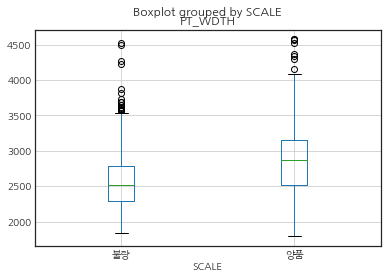

In [48]:
#2.PT_WDTH
df_raw.boxplot(column='PT_WDTH', by='SCALE')

In [49]:
#양품과 불량품의 철판 폭에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['PT_WDTH']
df2 = df_raw[df_raw['SCALE']=='양품']['PT_WDTH']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : -5.641
p-value : 0.000


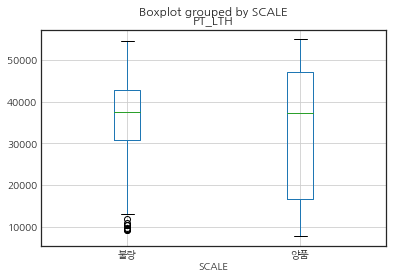

In [50]:
#3.PT_LTH
df_raw.boxplot(column='PT_LTH', by='SCALE')

In [51]:
#양품과 불량품의 철판 길이에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['PT_LTH']
df2 = df_raw[df_raw['SCALE']=='양품']['PT_LTH']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 2.706
p-value : 0.007


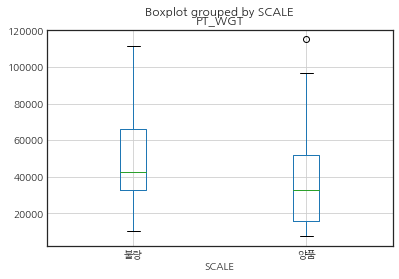

In [52]:
#4.PT_WGT
df_raw.boxplot(column='PT_WGT', by='SCALE')

In [53]:
#양품과 불량품의 철판 중량에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['PT_WGT']
df2 = df_raw[df_raw['SCALE']=='양품']['PT_WGT']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 6.007
p-value : 0.000


In [54]:
#5.FUR_NO_ROW
df_raw['FUR_NO_ROW'].value_counts()

1    362
2    358
Name: FUR_NO_ROW, dtype: int64

변수가 연속형이지만 1과 2만을 값으로 가짐을 볼 수 있다. 따라서 자료형을 범주형으로 바꾸고 막대그래프를 그리자.

In [55]:
df_raw['FUR_NO_ROW'] = np.where(df_raw['FUR_NO_ROW'] == 1, '1', '2')

In [56]:
df_raw.select_dtypes('object').apply(pd.Series.nunique, axis=0)

SCALE          2
SPEC          66
STEEL_KIND     9
FUR_NO         3
FUR_NO_ROW     2
HSB            2
WORK_GR        4
dtype: int64

FUR_NO_ROW 가 범주형으로 인식하여 위의 결과가 나옴을 볼 수 있다.

<function matplotlib.pyplot.show(*args, **kw)>

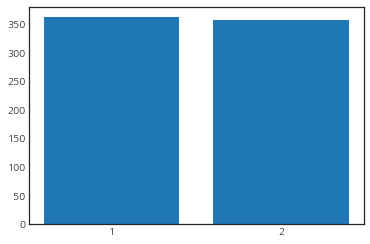

In [57]:
#가열로 작업 순번
FNR = df_raw['FUR_NO_ROW'].value_counts().sort_index()
plt.bar(FNR.index, FNR)
plt.show

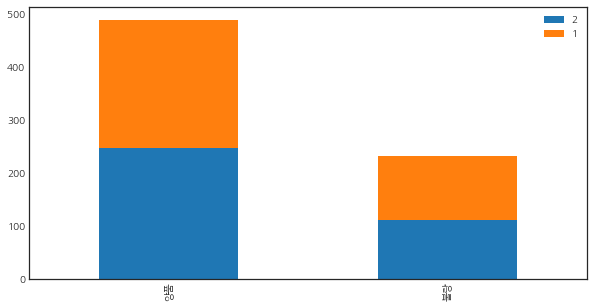

In [58]:
bar_chart('FUR_NO_ROW')

작업순번과는 거의 차이가 없음을 확인할 수 있다.

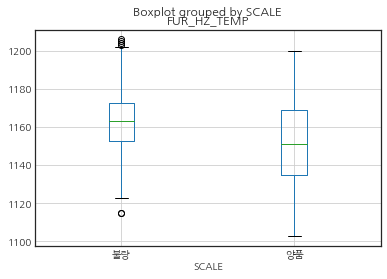

In [59]:
#6.FUR_HZ_TEMP
df_raw.boxplot(column='FUR_HZ_TEMP', by='SCALE')

In [60]:
#양품과 불량품의 가열로 가열대 온도에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_HZ_TEMP']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_HZ_TEMP']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 6.850
p-value : 0.000


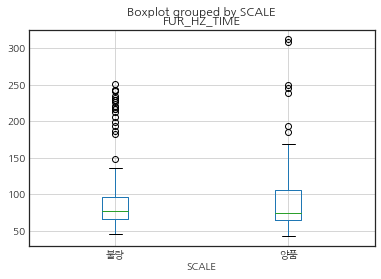

In [61]:
#7.FUR_HZ_TIME
df_raw.boxplot(column='FUR_HZ_TIME', by='SCALE')

In [62]:
#양품과 불량품의 가열로 가열대 시간에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_HZ_TIME']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_HZ_TIME']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 1.507
p-value : 0.132


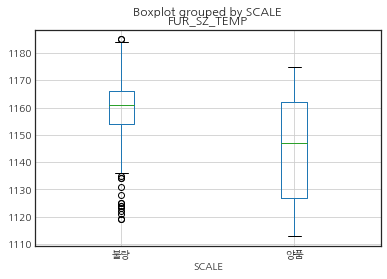

In [63]:
#8.FUR_SZ_TEMP
df_raw.boxplot(column='FUR_SZ_TEMP', by='SCALE')

In [64]:
#양품과 불량품의 가열로 균열대 온도에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_SZ_TEMP']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_SZ_TEMP']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 10.833
p-value : 0.000


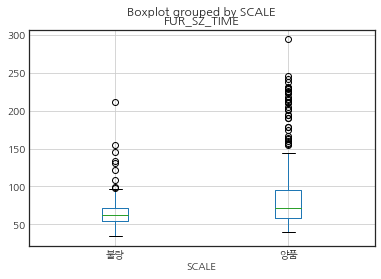

In [65]:
#9.FUR_SZ_TIME
df_raw.boxplot(column='FUR_SZ_TIME', by='SCALE')

In [66]:
#양품과 불량품의 가열로 균열대 시간에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_SZ_TIME']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_SZ_TIME']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : -6.629
p-value : 0.000


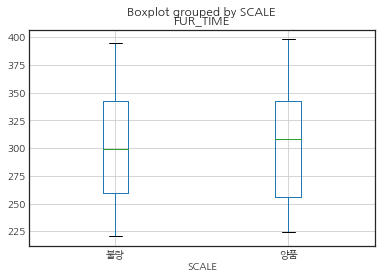

In [67]:
#10.FUR_TIME
df_raw.boxplot(column='FUR_TIME', by='SCALE')

In [68]:
#양품과 불량품의 가열로 시간에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_TIME']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_TIME']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : -1.320
p-value : 0.187


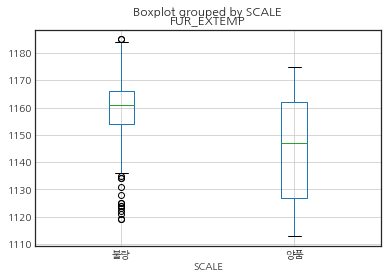

In [69]:
#11.FUR_EXTEMP
df_raw.boxplot(column='FUR_EXTEMP', by='SCALE')

In [70]:
#양품과 불량품의 압연온도에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['FUR_EXTEMP']
df2 = df_raw[df_raw['SCALE']=='양품']['FUR_EXTEMP']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 10.833
p-value : 0.000


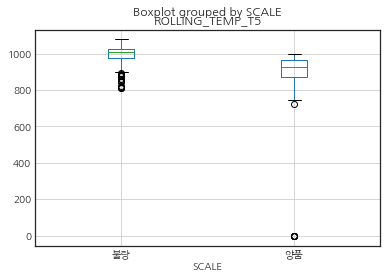

In [71]:
#12.ROLLING_TEMP_T5
df_raw.boxplot(column='ROLLING_TEMP_T5', by='SCALE')

### 양품의 이상치 중 온도가 0인 것은 오류일 것으로 판단되므로 제거한다.

In [72]:
np.where(df_raw['ROLLING_TEMP_T5'] <= 600)

(array([ 41, 184, 185, 494, 495, 496]),)

In [73]:
df_raw = df_raw.drop([41, 184, 185, 494, 495, 496], axis=0)

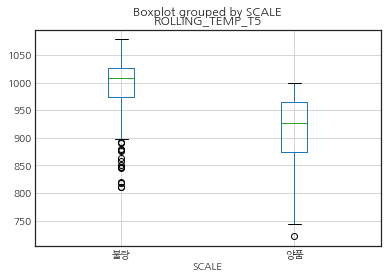

In [74]:
#12.ROLLING_TEMP_T5
df_raw.boxplot(column='ROLLING_TEMP_T5', by='SCALE')

In [75]:
#양품과 불량품의 가열대 온도에 차이가 있는지 검정 : 2-sample t-test
df1 = df_raw[df_raw['SCALE']=='불량']['ROLLING_TEMP_T5']
df2 = df_raw[df_raw['SCALE']=='양품']['ROLLING_TEMP_T5']

t_result = stats.ttest_ind(df1, df2)

t, p = t_result.statistic.round(3), t_result.pvalue.round(3)

print('[2-sample t test]')
print('\nt검정통계량 : %.3f' %t)
print('p-value : %.3f' %p)

[2-sample t test]

t검정통계량 : 17.680
p-value : 0.000


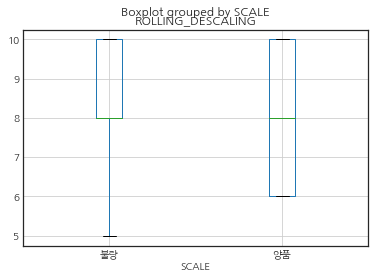

In [76]:
#13.ROLLING_DESCALING
df_raw.boxplot(column='ROLLING_DESCALING', by='SCALE')

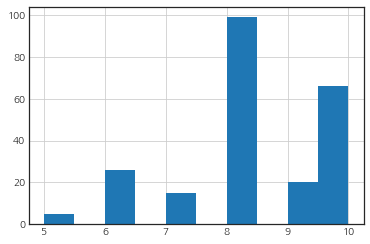

In [77]:
#13. ROLLING_DESCALING
df_raw[df_raw['SCALE']=='불량']['ROLLING_DESCALING'].hist()

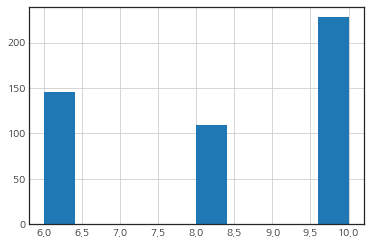

In [78]:
df_raw[df_raw['SCALE']=='양품']['ROLLING_DESCALING'].hist()

In [79]:
df_raw['ROLLING_DESCALING'].value_counts()

10    294
8     208
6     172
9      20
7      15
5       5
Name: ROLLING_DESCALING, dtype: int64

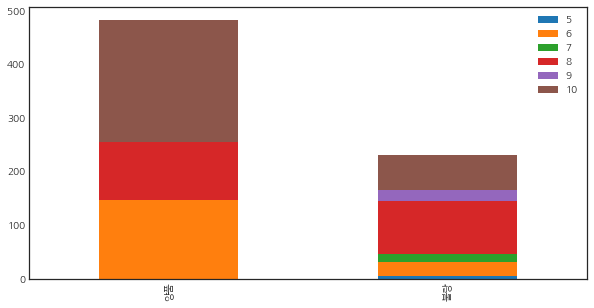

In [80]:
bar_chart('ROLLING_DESCALING')

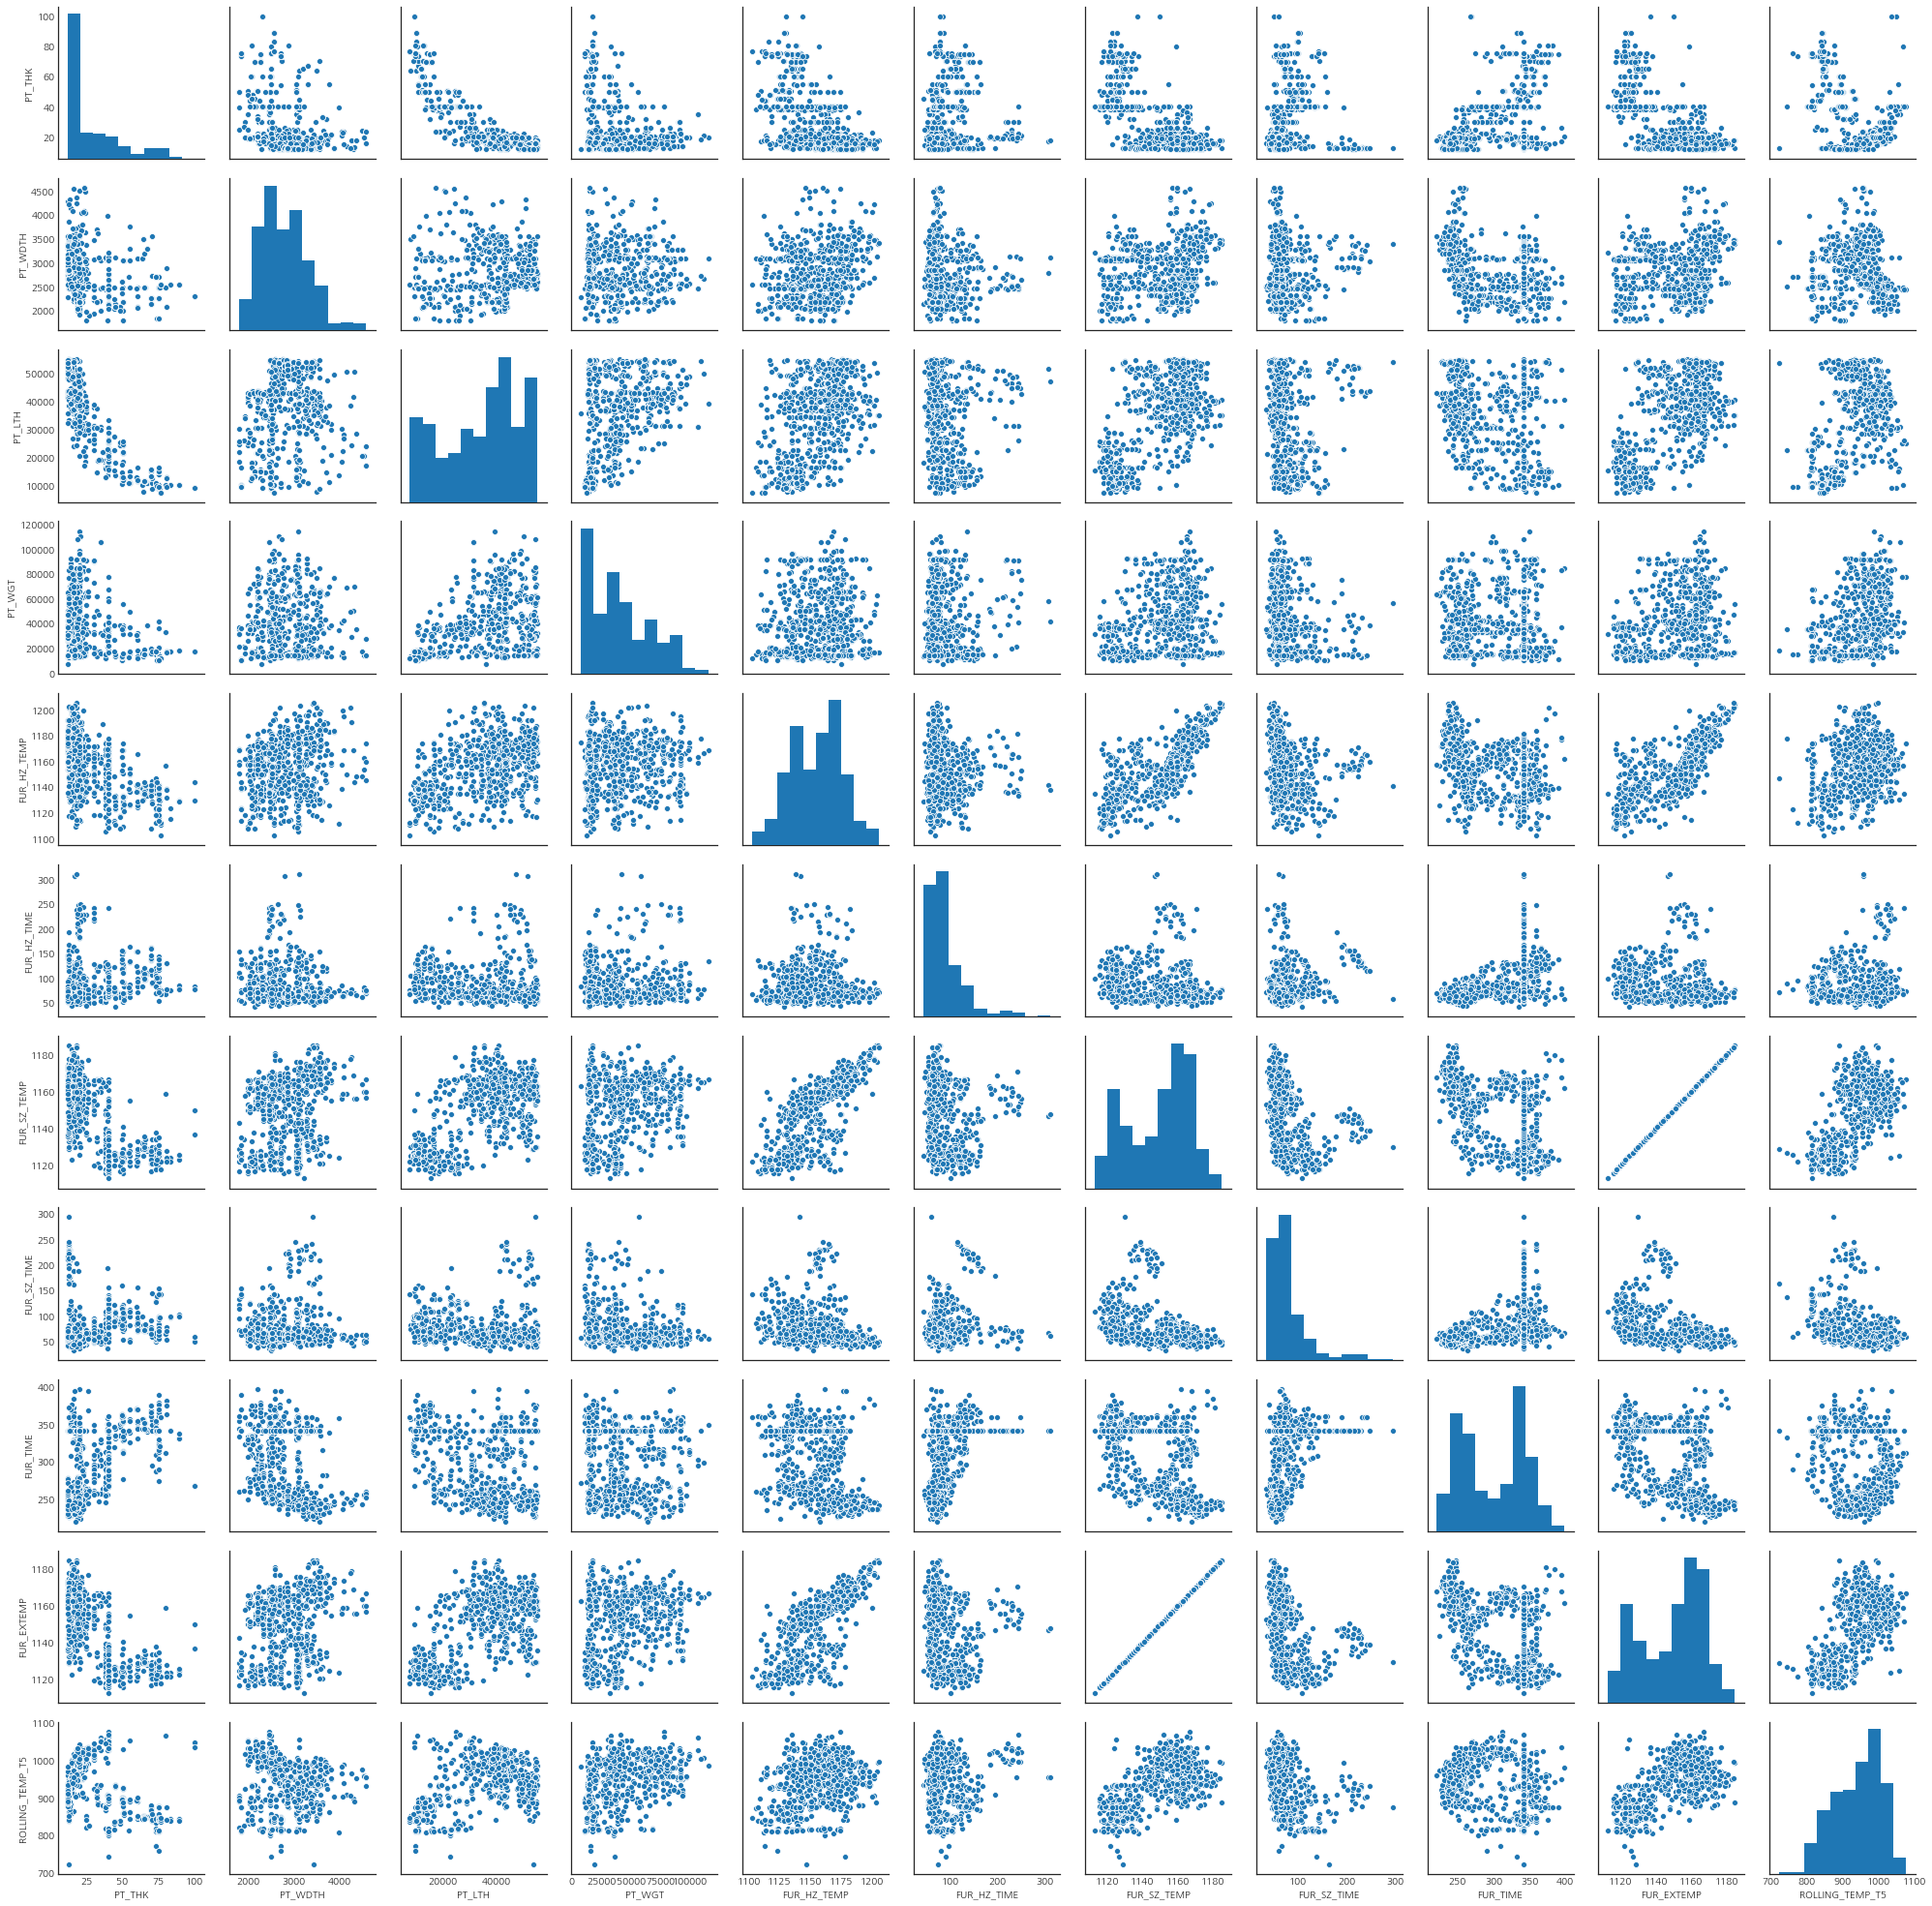

In [81]:
#연속형 변수들 간에 상관관계
df_raw_sm = df_raw.drop(['SCALE','SPEC','STEEL_KIND','FUR_NO','HSB','WORK_GR',
                         'FUR_NO_ROW','ROLLING_DESCALING'],axis=1)
sns.pairplot(df_raw_sm)

In [82]:
df_raw_sm.corr()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,FUR_EXTEMP,ROLLING_TEMP_T5
PT_THK,1.000000,-0.313982,-0.862009,-0.393838,-0.519935,0.159674,-0.691723,0.117810,0.406057,-0.691723,-0.502704
PT_WDTH,-0.313982,1.000000,0.121079,0.030278,0.180829,-0.122307,0.229158,0.019332,-0.392895,0.229158,-0.112685
PT_LTH,-0.862009,0.121079,1.000000,0.449407,0.468151,-0.075353,0.641383,-0.072198,-0.244587,0.641383,0.434156
PT_WGT,-0.393838,0.030278,0.449407,1.000000,0.149540,0.012484,0.356296,-0.191994,-0.053666,0.356296,0.420157
FUR_HZ_TEMP,-0.519935,0.180829,0.468151,0.149540,1.000000,-0.112322,0.770410,-0.224628,-0.341638,0.770410,0.356122
FUR_HZ_TIME,0.159674,-0.122307,-0.075353,0.012484,-0.112322,1.000000,-0.201441,0.177512,0.474999,-0.201441,0.005758
FUR_SZ_TEMP,-0.691723,0.229158,0.641383,0.356296,0.770410,-0.201441,1.000000,-0.455848,-0.471246,1.000000,0.661994
FUR_SZ_TIME,0.117810,0.019332,-0.072198,-0.191994,-0.224628,0.177512,-0.455848,1.000000,0.448765,-0.455848,-0.379285
FUR_TIME,0.406057,-0.392895,-0.244587,-0.053666,-0.341638,0.474999,-0.471246,0.448765,1.000000,-0.471246,-0.209814
FUR_EXTEMP,-0.691723,0.229158,0.641383,0.356296,0.770410,-0.201441,1.000000,-0.455848,-0.471246,1.000000,0.661994


FUR_SZ_TEMP 와 FUR_EXTEMP 는 상관계수가 1이므로 하나의 변수는 제거해도 된다.

In [83]:
df_raw = df_raw.drop('FUR_EXTEMP', axis=1)

In [84]:
df_raw.shape

(714, 18)

In [85]:
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_NO_ROW,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1,1144,116,1133,59,282,934,적용,8,2조
1,양품,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,2,1144,122,1135,53,283,937,적용,8,2조
2,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1,1129,116,1121,55,282,889,적용,8,3조
3,양품,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,2,1152,125,1127,68,316,885,적용,8,3조
4,양품,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1,1140,134,1128,48,314,873,적용,8,1조


In [86]:
df_raw.corr()

,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_HZ_TIME,FUR_SZ_TEMP,FUR_SZ_TIME,FUR_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING
PT_THK,1.000000,-0.313982,-0.862009,-0.393838,-0.519935,0.159674,-0.691723,0.117810,0.406057,-0.502704,-0.836348
PT_WDTH,-0.313982,1.000000,0.121079,0.030278,0.180829,-0.122307,0.229158,0.019332,-0.392895,-0.112685,0.342620
PT_LTH,-0.862009,0.121079,1.000000,0.449407,0.468151,-0.075353,0.641383,-0.072198,-0.244587,0.434156,0.807222
PT_WGT,-0.393838,0.030278,0.449407,1.000000,0.149540,0.012484,0.356296,-0.191994,-0.053666,0.420157,0.234354
FUR_HZ_TEMP,-0.519935,0.180829,0.468151,0.149540,1.000000,-0.112322,0.770410,-0.224628,-0.341638,0.356122,0.464936
FUR_HZ_TIME,0.159674,-0.122307,-0.075353,0.012484,-0.112322,1.000000,-0.201441,0.177512,0.474999,0.005758,-0.135083
FUR_SZ_TEMP,-0.691723,0.229158,0.641383,0.356296,0.770410,-0.201441,1.000000,-0.455848,-0.471246,0.661994,0.643536
FUR_SZ_TIME,0.117810,0.019332,-0.072198,-0.191994,-0.224628,0.177512,-0.455848,1.000000,0.448765,-0.379285,-0.107490
FUR_TIME,0.406057,-0.392895,-0.244587,-0.053666,-0.341638,0.474999,-0.471246,0.448765,1.000000,-0.209814,-0.360341
ROLLING_TEMP_T5,-0.502704,-0.112685,0.434156,0.420157,0.356122,0.005758,0.661994,-0.379285,-0.209814,1.000000,0.370125


In [87]:
#위의 탐색적 분석을 통해 얻었던 정보를 활용하여 SCALE 변수에 영향을 많이 주지 않는 변수를 제거한다.

df_raw = df_raw.drop(['FUR_HZ_TIME','FUR_TIME', 'FUR_NO_ROW'], axis=1)

## 3. 모델 생성
### (1) 의사결정 나무

In [88]:
from statsmodels.api import Logit
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [89]:
#명목형 변수 목록
obj_cols = df_raw.select_dtypes('object').columns
for col in obj_cols :
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

SCALE : 2
SPEC : 66
STEEL_KIND : 9
FUR_NO : 3
HSB : 2
WORK_GR : 4


In [90]:
df_raw['SCALE'] = np.where(df_raw['SCALE'] == '양품',0,1)
df_raw.head()

,SCALE,SPEC,STEEL_KIND,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_NO,FUR_HZ_TEMP,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,HSB,ROLLING_DESCALING,WORK_GR
0,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1144,1133,59,934,적용,8,2조
1,0,AB/EH32-TM,T1,32.25,3707,15109,14180,1호기,1144,1135,53,937,적용,8,2조
2,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1129,1121,55,889,적용,8,3조
3,0,NV-E36-TM,T8,33.27,3619,19181,18130,2호기,1152,1127,68,885,적용,8,3조
4,0,BV-EH36-TM,T8,38.33,3098,13334,12430,3호기,1140,1128,48,873,적용,8,1조


In [91]:
df_raw['SCALE'].value_counts()

0    483
1    231
Name: SCALE, dtype: int64

In [92]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1144,1133,59,934,8,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,1144,1135,53,937,8,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1129,1121,55,889,8,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,1152,1127,68,885,8,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1140,1128,48,873,8,...,1,0,0,1,0,1,1,0,0,0


In [93]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['SCALE']
df_raw_x = df_raw_dummy.drop('SCALE',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (499, 93)
train data Y size : (499,)
test data X size : (215, 93)
test data Y size : (215,)


In [94]:
#GridSearchCV를 이용한 최적 parameter 찾기

para_depth = [depth for depth in range(1,11)]
para_split=[n_split * 10 for n_split in range(1,11)]
para_leaf=[n_leaf * 2 for n_leaf in range(1,11)]

estimator = DecisionTreeClassifier()

param_grid = {'max_depth': para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model:\n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score:\n{}'.format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

best parameter:
{'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 10}

best score:
0.97


In [95]:
tree_final = DecisionTreeClassifier(max_depth = 8, min_samples_split=10, min_samples_leaf=2,
                                   random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

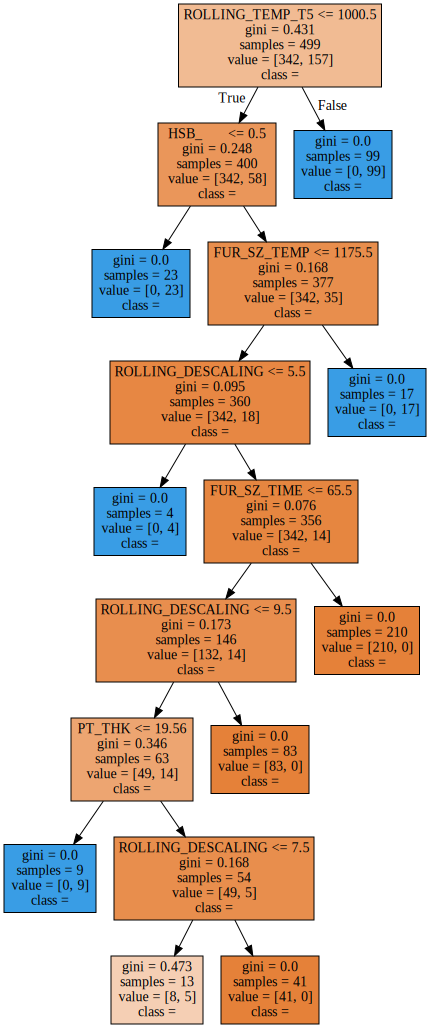

In [96]:
v_feature_name = df_train_x.columns

export_graphviz(tree_final, out_file='tree_final.dot', class_names=['양품','불량'],
               feature_names = v_feature_name, impurity = True, filled =True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [97]:
#최종 모델 평가

y_pred = tree_final.predict(df_test_x)
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.981

Confusion matrix: 
[[141   0]
 [  4  70]]


In [98]:
#결론도출
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,ROLLING_TEMP_T5,0.555
88,HSB_적용,0.171
5,FUR_SZ_TEMP,0.140
8,ROLLING_DESCALING,0.066
0,PT_THK,0.061
6,FUR_SZ_TIME,0.008
60,SPEC_NK-KA32,0.000
68,SPEC_NV-D32-TM,0.000
67,SPEC_NV-B,0.000
66,SPEC_NV-A36-TM,0.000


Text(0, 0.5, '설명변수')

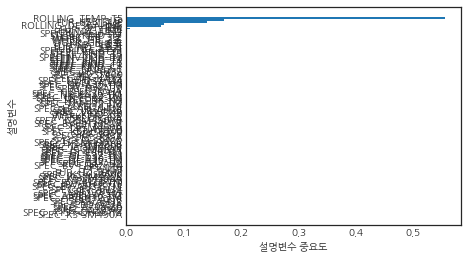

In [99]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

SPEC 의 변수값이 너무 많고 중요도도 없기(?) 때문에 제외한다.

In [100]:
df_raw = df_raw.drop('SPEC', axis=1)

In [101]:
#명목형 변수 목록
obj_cols = df_raw.select_dtypes('object').columns
for col in obj_cols :
    _n = len(df_raw[col].value_counts())
    print(col, ":", str(_n))

STEEL_KIND : 9
FUR_NO : 3
HSB : 2
WORK_GR : 4


In [102]:
df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,SCALE,PT_THK,PT_WDTH,PT_LTH,PT_WGT,FUR_HZ_TEMP,FUR_SZ_TEMP,FUR_SZ_TIME,ROLLING_TEMP_T5,ROLLING_DESCALING,...,STEEL_KIND_T8,FUR_NO_1호기,FUR_NO_2호기,FUR_NO_3호기,HSB_미적용,HSB_적용,WORK_GR_1조,WORK_GR_2조,WORK_GR_3조,WORK_GR_4조
0,0,32.25,3707,15109,14180,1144,1133,59,934,8,...,0,1,0,0,0,1,0,1,0,0
1,0,32.25,3707,15109,14180,1144,1135,53,937,8,...,0,1,0,0,0,1,0,1,0,0
2,0,33.27,3619,19181,18130,1129,1121,55,889,8,...,1,0,1,0,0,1,0,0,1,0
3,0,33.27,3619,19181,18130,1152,1127,68,885,8,...,1,0,1,0,0,1,0,0,1,0
4,0,38.33,3098,13334,12430,1140,1128,48,873,8,...,1,0,0,1,0,1,1,0,0,0


In [103]:
#목표변수, 설명변수 데이터 지정
df_raw_y = df_raw_dummy['SCALE']
df_raw_x = df_raw_dummy.drop('SCALE',axis=1,inplace=False)

#데이터 분할 (train:test = 7:3)
df_train_x,df_test_x,df_train_y,df_test_y = train_test_split(df_raw_x,df_raw_y,
                                                            test_size=0.3)

print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("test data X size : {}".format(df_test_x.shape))
print("test data Y size : {}".format(df_test_y.shape))

train data X size : (499, 27)
train data Y size : (499,)
test data X size : (215, 27)
test data Y size : (215,)


In [104]:
#GridSearchCV를 이용한 최적 parameter 찾기

para_depth = [depth for depth in range(1,11)]
para_split=[n_split * 10 for n_split in range(1,11)]
para_leaf=[n_leaf * 2 for n_leaf in range(1,11)]

estimator = DecisionTreeClassifier()

param_grid = {'max_depth': para_depth, 'min_samples_split':para_split, 'min_samples_leaf':para_leaf}

grid_dt = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_dt.fit(df_train_x, df_train_y)

print('best estimator model:\n{}'.format(grid_dt.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_dt.best_params_))
print('\nbest score:\n{}'.format(grid_dt.best_score_.round(3)))

best estimator model:
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

best parameter:
{'max_depth': 8, 'min_samples_leaf': 2, 'min_samples_split': 10}

best score:
0.964


In [105]:
tree_final = DecisionTreeClassifier(max_depth = 4, min_samples_split=10, min_samples_leaf=2,
                                   random_state=1234)
tree_final.fit(df_train_x, df_train_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1234,
            splitter='best')

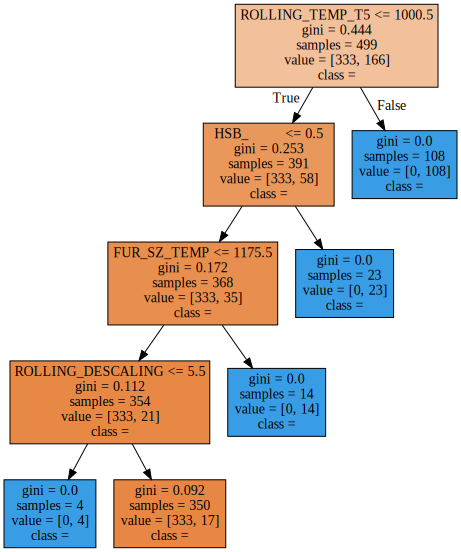

In [106]:
v_feature_name = df_train_x.columns

export_graphviz(tree_final, out_file='tree_final.dot', class_names=['양품','불량'],
               feature_names = v_feature_name, impurity = True, filled =True)
with open('tree_final.dot') as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 가열대의 온도가 1000.5 초과이면 불량
### 가열대의 온도가 1000.5 이상이면 양품이지만 HSB를 적용하지 않으면 불량, 적용하면 양품
###  가열대 균열대 온도가 1175.5 이하이면 양품이고 그렇지 않으면 불량
### 압연중 descaling 횟수가 5.5 이하이면 불량이고 그렇지않으면 양품이다.

In [107]:
#최종 모델 평가

y_pred = tree_final.predict(df_test_x)
print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion matrix: \n{}".format(confusion_matrix(df_test_y,y_pred)))

Accuracy:0.977

Confusion matrix: 
[[150   0]
 [  5  60]]


In [108]:
#결론도출
df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = tree_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,ROLLING_TEMP_T5,0.649
21,HSB_미적용,0.187
5,FUR_SZ_TEMP,0.126
8,ROLLING_DESCALING,0.038
0,PT_THK,0.000
15,STEEL_KIND_T5,0.000
25,WORK_GR_3조,0.000
24,WORK_GR_2조,0.000
23,WORK_GR_1조,0.000
22,HSB_적용,0.000


Text(0, 0.5, '설명변수')

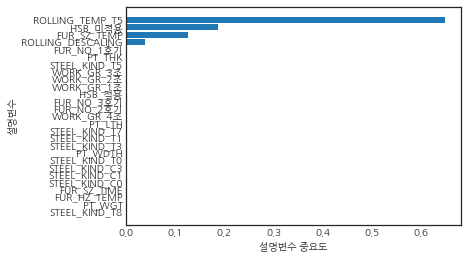

In [109]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수 중요도')
plt.ylabel('설명변수')

### (2) random forest

In [110]:
para_depth = [depth for depth in range(1,11)]
para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]

estimator = RandomForestClassifier(n_estimators=100, random_state=1234)

param_grid = {'max_depth': para_depth, 'min_samples_leaf':para_leaf}

grid_rf = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_rf.fit(df_train_x, df_train_y)

print('best estimator model:\n{}'.format(grid_rf.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_rf.best_params_))
print('\nbest score:\n{}'.format(grid_rf.best_score_.round(3)))

best estimator model:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False)

best parameter:
{'max_depth': 4, 'min_samples_leaf': 10}

best score:
0.884


In [111]:
rf_final = RandomForestClassifier(min_samples_leaf = 10, max_depth=3,
                                 n_estimators=100, random_state=1234)
rf_final.fit(df_train_x, df_train_y)
y_pred = rf_final.predict(df_test_x)

print('Accuracy on training set:{:.3f}'.format(rf_final.score(df_train_x,df_train_y)))
print('Accuracy on test set:{:.3f}'.format(rf_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy on training set:0.910
Accuracy on test set:0.921
Confusion Matrix:
[[150   0]
 [ 17  48]]


In [112]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = rf_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,ROLLING_TEMP_T5,0.380
1,PT_WDTH,0.110
5,FUR_SZ_TEMP,0.103
4,FUR_HZ_TEMP,0.061
21,HSB_미적용,0.051
9,STEEL_KIND_C0,0.048
0,PT_THK,0.046
8,ROLLING_DESCALING,0.044
2,PT_LTH,0.044
3,PT_WGT,0.037


Text(0, 0.5, '변수')

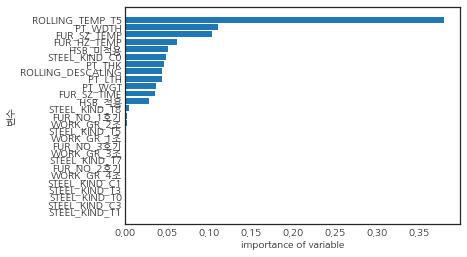

In [113]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('importance of variable')
plt.ylabel('변수')

### (3) gradient boosting

In [114]:
para_lr = [lr *0.1 for lr in range(1,10)]
para_depth = [depth for depth in range(1,11)]
para_leaf = [n_leaf * 10 for n_leaf in range(1,11)]

estimator = GradientBoostingClassifier(n_estimators=100, random_state=1234)

param_grid = {'learning_rate': para_lr, 'max_depth': para_depth, 'min_samples_leaf':para_leaf}

grid_gb = GridSearchCV(estimator, param_grid, scoring='accuracy', n_jobs=-1)
grid_gb.fit(df_train_x, df_train_y)

print('best estimator model:\n{}'.format(grid_gb.best_estimator_))
print('\nbest parameter:\n{}'.format(grid_gb.best_params_))
print('\nbest score:\n{}'.format(grid_gb.best_score_.round(3)))

best estimator model:
GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=2,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=10, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=1234,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

best parameter:
{'learning_rate': 0.8, 'max_depth': 2, 'min_samples_leaf': 10}

best score:
0.982


In [115]:
gb_final = GradientBoostingClassifier(min_samples_leaf = 10 , max_depth=2,
                                 n_estimators=100, learning_rate=0.2, random_state=1234)
gb_final.fit(df_train_x, df_train_y)
y_pred = gb_final.predict(df_test_x)

print('Accuracy on training set:{:.3f}'.format(gb_final.score(df_train_x,df_train_y)))
print('Accuracy on test set:{:.3f}'.format(gb_final.score(df_test_x,df_test_y)))
print('Confusion Matrix:\n{}'.format(confusion_matrix(df_test_y,y_pred)))

Accuracy on training set:1.000
Accuracy on test set:0.995
Confusion Matrix:
[[150   0]
 [  1  64]]


In [116]:
v_feature_name = df_train_x.columns

df_importance = pd.DataFrame()
df_importance['Feature'] = v_feature_name
df_importance['Importance'] = gb_final.feature_importances_

df_importance.sort_values('Importance', ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
7,ROLLING_TEMP_T5,0.601
22,HSB_적용,0.166
5,FUR_SZ_TEMP,0.115
8,ROLLING_DESCALING,0.070
0,PT_THK,0.020
21,HSB_미적용,0.017
6,FUR_SZ_TIME,0.003
4,FUR_HZ_TEMP,0.002
16,STEEL_KIND_T7,0.001
3,PT_WGT,0.001


Text(0, 0.5, '설명변수')

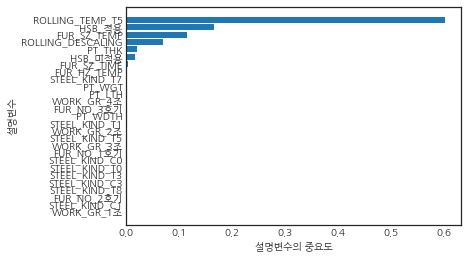

In [117]:
df_importance.sort_values('Importance', ascending=True, inplace=True)
coordinates = range(len(df_importance))
plt.barh(y=coordinates, width = df_importance['Importance'])
plt.yticks(coordinates, df_importance['Feature'])
plt.xlabel('설명변수의 중요도')
plt.ylabel('설명변수')

### (4) KNN

In [118]:
#이웃 수 증가에 다른 정확도 변화

train_accuracy1 = []; test_accuracy1 = []
para_n_neighbors = [i for i in range(1,16)]

for v_n_neighbors in para_n_neighbors:
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors)
    knn.fit(df_train_x, df_train_y)
    train_accuracy1.append(knn.score(df_train_x, df_train_y))
    test_accuracy1.append(knn.score(df_test_x, df_test_y))
    
df_accuracy_neighbors = pd.DataFrame()
df_accuracy_neighbors['Neighbors'] = para_n_neighbors
df_accuracy_neighbors['TrainAccuracy'] = train_accuracy1
df_accuracy_neighbors['TestAccuracy'] = test_accuracy1
df_accuracy_neighbors.round(3)

,Neighbors,TrainAccuracy,TestAccuracy
0,1,1.000,0.753
1,2,0.852,0.744
2,3,0.856,0.753
3,4,0.800,0.730
4,5,0.806,0.772
5,6,0.774,0.758
6,7,0.780,0.753
7,8,0.768,0.721
8,9,0.762,0.726
9,10,0.760,0.716


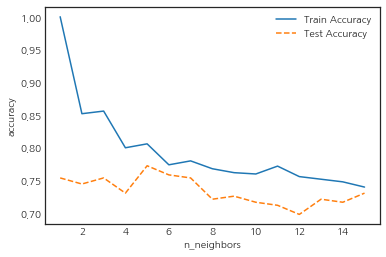

In [119]:
plt.plot(para_n_neighbors, train_accuracy1, linestyle='-', label='Train Accuracy')
plt.plot(para_n_neighbors, test_accuracy1, linestyle='--', label='Test Accuracy')
plt.ylabel('accuracy'); plt.xlabel('n_neighbors')
plt.legend()

In [120]:
#가중치별 이웃 수 증가에 따른 정확도 변화

train_accuracy1 = []; test_accuracy1 = []
para_n_neighbors = [i for i in range(1,11)] * 2
para_weights = (['uniform']) * 10 + (['distance'] * 10)

for (v_n_neighbors, v_weights) in zip(para_n_neighbors, para_weights):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, weights = v_weights)
    knn.fit(df_train_x, df_train_y)
    train_accuracy1.append(knn.score(df_train_x, df_train_y))
    test_accuracy1.append(knn.score(df_test_x, df_test_y))
    
df_accuracy_weights = pd.DataFrame()
df_accuracy_weights['Neighbors'] = para_n_neighbors
df_accuracy_weights['Weights'] = para_weights
df_accuracy_weights['TrainAccuracy'] = train_accuracy1
df_accuracy_weights['TestAccuracy'] = test_accuracy1
df_accuracy_weights.round(3)

,Neighbors,Weights,TrainAccuracy,TestAccuracy
0,1,uniform,1.000,0.753
1,2,uniform,0.852,0.744
2,3,uniform,0.856,0.753
3,4,uniform,0.800,0.730
4,5,uniform,0.806,0.772
5,6,uniform,0.774,0.758
6,7,uniform,0.780,0.753
7,8,uniform,0.768,0.721
8,9,uniform,0.762,0.726
9,10,uniform,0.760,0.716


In [121]:
df_accuracy_weights_pivot = df_accuracy_weights.pivot(index='Neighbors', columns='Weights',
                                                     values=['TrainAccuracy', 'TestAccuracy'])
df_accuracy_weights_pivot

TrainAccuracy           TestAccuracy          
Weights        distance   uniform     distance   uniform
Neighbors                                               
1                   1.0  1.000000     0.753488  0.753488
2                   1.0  0.851703     0.753488  0.744186
3                   1.0  0.855711     0.767442  0.753488
4                   1.0  0.799599     0.748837  0.730233
5                   1.0  0.805611     0.772093  0.772093
6                   1.0  0.773547     0.776744  0.758140
7                   1.0  0.779559     0.786047  0.753488
8                   1.0  0.767535     0.781395  0.720930
9                   1.0  0.761523     0.781395  0.725581
10                  1.0  0.759519     0.767442  0.716279

In [122]:
level0 = df_accuracy_weights_pivot.columns.get_level_values(0)
level1 = df_accuracy_weights_pivot.columns.get_level_values(1)
df_accuracy_weights_pivot.columns = level0 + '_' + level1
df_accuracy_weights_pivot.head()

,TrainAccuracy_distance,TrainAccuracy_uniform,TestAccuracy_distance,TestAccuracy_uniform
Neighbors,,,,
1,1.0,1.000000,0.753488,0.753488
2,1.0,0.851703,0.753488,0.744186
3,1.0,0.855711,0.767442,0.753488
4,1.0,0.799599,0.748837,0.730233
5,1.0,0.805611,0.772093,0.772093


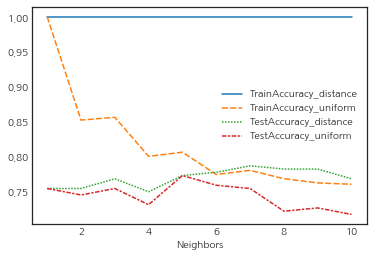

In [123]:
sns.lineplot(data = df_accuracy_weights_pivot)

In [124]:
#거리 계산 방법별 이웃 수 증가에 따른 정확도 변화
train_accuracy1 =[]; test_accuracy1 =[]

para_n_neighbors = [i for i in range(1,11)] * 3

para_metric = ['minkowski'] * 10 + ['euclidean'] * 10  + ['manhattan'] * 10

for (v_n_neighbors, v_metric) in zip(para_n_neighbors, para_metric):
    knn = KNeighborsClassifier(n_neighbors = v_n_neighbors, metric = v_metric, weights = 'uniform')
    knn.fit(df_train_x, df_train_y)
    train_accuracy1.append(knn.score(df_train_x, df_train_y))
    test_accuracy1.append(knn.score(df_test_x, df_test_y))
    
df_accuracy_metric = pd.DataFrame()
df_accuracy_metric['Neighbors'] = para_n_neighbors
df_accuracy_metric['Metric'] = para_metric
df_accuracy_metric['TrainAccuracy'] = train_accuracy1
df_accuracy_metric['TestAccuracy'] = test_accuracy1
df_accuracy_metric.round(3)

,Neighbors,Metric,TrainAccuracy,TestAccuracy
0,1,minkowski,1.000,0.753
1,2,minkowski,0.852,0.744
2,3,minkowski,0.856,0.753
3,4,minkowski,0.800,0.730
4,5,minkowski,0.806,0.772
5,6,minkowski,0.774,0.758
6,7,minkowski,0.780,0.753
7,8,minkowski,0.768,0.721
8,9,minkowski,0.762,0.726
9,10,minkowski,0.760,0.716


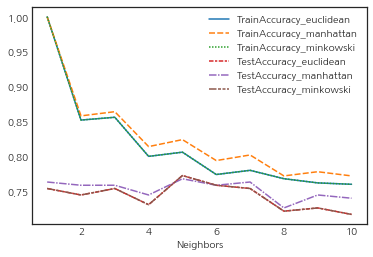

In [125]:
df_accuracy_metric_pivot = df_accuracy_metric.pivot(index='Neighbors', columns='Metric',
                                                   values=['TrainAccuracy', 'TestAccuracy'])
level0 = df_accuracy_metric_pivot.columns.get_level_values(0)
level1 = df_accuracy_metric_pivot.columns.get_level_values(1)
df_accuracy_metric_pivot.columns = level0 + '_' + level1
sns.lineplot(data = df_accuracy_metric_pivot)

In [126]:
#최종모델
knn_model = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'manhattan')
knn_model.fit(df_train_x, df_train_y)

y_pred = knn_model.predict(df_test_x)

print("Accuracy on training set:{0:.3f}".format(knn_model.score(df_train_x, df_train_y)))
print("Accuracy on test set:{0:.3f}".format(knn_model.score(df_test_x,df_test_y)))
print('Confusion matrix:\n{}'.format(confusion_matrix(df_test_y, y_pred)))

Accuracy on training set:0.824
Accuracy on test set:0.767
Confusion matrix:
[[130  20]
 [ 30  35]]


## 4. 모델 평가/ 결론

In [127]:
from sklearn.metrics import f1_score, roc_curve, auc

In [128]:
#분석모델
model = ['Decision Tree', 'RandomForest', 'GradientBoosting', 'KNN']
#정확도 저장
train_accuracy = []; test_accuracy = []
#f1 저장
model_f1_score = []
#auc score 저장
model_auc = []

In [129]:
## 의사결정 나무

#train 정확도
train_accuracy.append(tree_final.score(df_train_x, df_train_y))
#test 정확도
test_accuracy.append(tree_final.score(df_test_x, df_test_y))
#예측값
y_pred = tree_final.predict(df_test_x)
#roc curve
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)
#auc저장
model_auc.append(roc_auc)

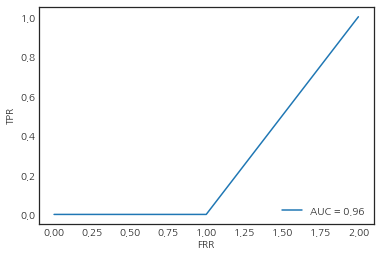

In [130]:
plt.plot(fpr, label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FRR')
plt.show()

In [131]:
model_f1_score.append(f1_score(df_test_y,y_pred))

In [132]:
## 랜덤포레스트

train_accuracy.append(rf_final.score(df_train_x,df_train_y))
test_accuracy.append(rf_final.score(df_test_x, df_test_y))
y_pred = rf_final.predict(df_test_x)
#roc curve
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)
#auc저장
model_auc.append(roc_auc)

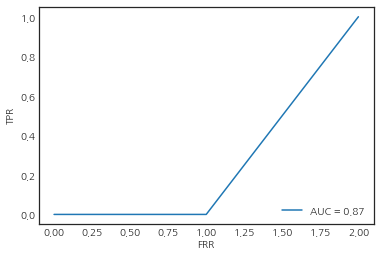

In [133]:
plt.plot(fpr, label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FRR')
plt.show()

In [134]:
model_f1_score.append(f1_score(df_test_y, y_pred))

In [135]:
## 그래디언트 부스팅

train_accuracy.append(gb_final.score(df_train_x,df_train_y))
test_accuracy.append(gb_final.score(df_test_x, df_test_y))
y_pred = gb_final.predict(df_test_x)
#roc curve
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)
#auc저장
model_auc.append(roc_auc)

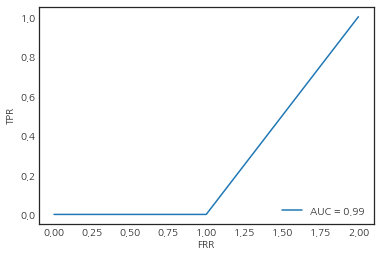

In [136]:
plt.plot(fpr, label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FRR')
plt.show()

In [137]:
model_f1_score.append(f1_score(df_test_y, y_pred))

In [138]:
## KNN

train_accuracy.append(knn_model.score(df_train_x,df_train_y))
test_accuracy.append(knn_model.score(df_test_x, df_test_y))
y_pred = knn_model.predict(df_test_x)
#roc curve
fpr, tpr, thresholds = roc_curve(df_test_y, y_pred)
roc_auc = auc(fpr, tpr)
#auc저장
model_auc.append(roc_auc)

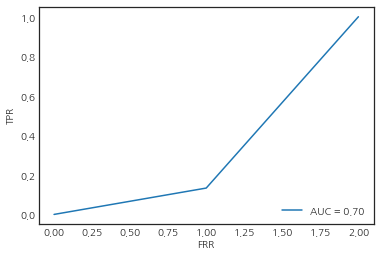

In [139]:
plt.plot(fpr, label='AUC = %0.2f'%roc_auc)
plt.legend(loc='lower right')
plt.ylabel('TPR'); plt.xlabel('FRR')
plt.show()

In [140]:
model_f1_score.append(f1_score(df_test_y, y_pred))

In [141]:
print(train_accuracy)

[0.9659318637274549, 0.9098196392785571, 1.0, 0.8236472945891784]


In [142]:
print(test_accuracy)

[0.9767441860465116, 0.9209302325581395, 0.9953488372093023, 0.7674418604651163]


In [143]:
print(model_f1_score)

[0.9600000000000001, 0.8495575221238938, 0.9922480620155039, 0.5833333333333334]


In [144]:
print(model_auc)

[0.9615384615384616, 0.8692307692307693, 0.9923076923076923, 0.7025641025641025]


In [145]:
df_eval = pd.DataFrame(index=model)
df_eval['TrainAccuracy'] = train_accuracy
df_eval['TestAccuracy'] = test_accuracy
df_eval['F1Score'] = model_f1_score
df_eval['AUC'] = model_auc
df_eval.round(3)

,TrainAccuracy,TestAccuracy,F1Score,AUC
Decision Tree,0.966,0.977,0.960,0.962
RandomForest,0.910,0.921,0.850,0.869
GradientBoosting,1.000,0.995,0.992,0.992
KNN,0.824,0.767,0.583,0.703


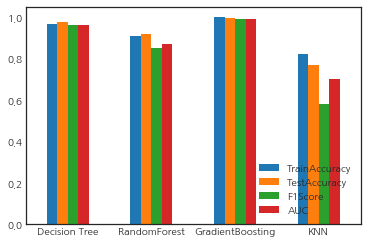

In [146]:
#정확도 bar plot 형성
df_eval.plot.bar(rot=0)
plt.legend(loc='lower right')
plt.grid(axis='Y')